In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder



#ratings = pd.read_csv('rating.csv')
ratings = pd.read_csv('ratings.csv')
ratings.head()


#movies = pd.read_csv('movie.csv')
movies = pd.read_csv('movies.csv')
movies.head()

#rand_userIds = np.random.choice(ratings['userId'].unique(), 
 #                               size=int(len(ratings['userId'].unique())*0.1), 
  #                              replace=False)

#ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

# change time stamps to years
ratingsConv = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.timestamp = ratingsConv.to_frame().timestamp.dt.year


# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

# Organise a bit, then save into feather-formatand clear from memory
#movies.sort_values(by='movieId', inplace=True)
#ratings.sort_values(by='userId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

# merge two dataframes 

df=ratings.merge(movies,on = 'movieId',how = 'inner')
    
# one-hot encoding for genres

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(df.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genres']) # Format into DataFrame to store later
df = df.join(df.genres.str.get_dummies().astype(int))
df.drop('genres', inplace=True, axis=1)

# Label encoding on the years

time_enc = LabelEncoder()
df['year'] = time_enc.fit_transform(df['timestamp'].values)
n_times = df['year'].unique()

print(df.head())



Number of movies Null values:  0
Number of ratings Null values:  0
   userId  movieId  rating  timestamp             title  (no genres listed)  \
0       1        1     4.0       2000  Toy Story (1995)                   0   
1       5        1     4.0       1996  Toy Story (1995)                   0   
2       7        1     4.5       2005  Toy Story (1995)                   0   
3      15        1     2.5       2017  Toy Story (1995)                   0   
4      17        1     4.5       2011  Toy Story (1995)                   0   

   Action  Adventure  Animation  Children  ...  Horror  IMAX  Musical  \
0       0          1          1         1  ...       0     0        0   
1       0          1          1         1  ...       0     0        0   
2       0          1          1         1  ...       0     0        0   
3       0          1          1         1  ...       0     0        0   
4       0          1          1         1  ...       0     0        0   

   Mystery  Romance

0         4.0
1         4.0
2         4.5
3         2.5
4         4.5
         ... 
100831    2.5
100832    4.5
100833    3.0
100834    3.5
100835    3.5
Name: rating, Length: 100836, dtype: float64
        userId  movieId  (no genres listed)  Action  Adventure  Animation  \
0            1        1                   0       0          1          1   
1            5        1                   0       0          1          1   
2            7        1                   0       0          1          1   
3           15        1                   0       0          1          1   
4           17        1                   0       0          1          1   
...        ...      ...                 ...     ...        ...        ...   
100831     610   160341                   0       1          0          0   
100832     610   160527                   0       1          0          0   
100833     610   160836                   0       1          0          0   
100834     610   163937        

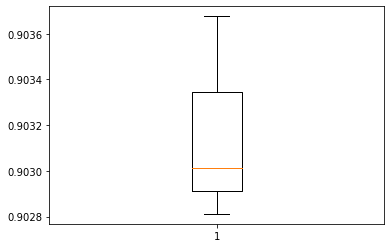

In [2]:
# train only on genres, userId, movieId
y = df['rating']
X = df.drop(columns = ['rating', 'title', 'timestamp', 'year'])

print(y)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

mses1 = []
for i in range(0, 3):
    rfc = RandomForestRegressor()
    rfc.fit(X_train, y_train)
    ypred = rfc.predict(X_test)
    print('Mean Squared Error (MSE): ' + str(mean_squared_error(y_test, ypred)))
    mses1.append(mean_squared_error(y_test, ypred))
plt.boxplot(mses1)
plt.show()

In [3]:
'''
# dictionary for all movieId's to map to a list of their genres

dic = {}

for index, row in movies.iterrows():
    allGenres = row['genres']
    #indGenres = allGenres.split('|')
    dic[row['movieId']] = allGenres 
    
# one hot-encodings
# https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970
#print(ratings)
for ind in ratings.index:
    curGenres = dic[ratings['movieId'][ind]]
    #print(curGenres)
    ratings.at[ind, 'genre'] = curGenres
    #print(ratings.at[ind, genre])

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(ratings.genre.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
ratings = ratings.join(ratings.genre.str.get_dummies().astype(int))
ratings.drop('genre', inplace=True, axis=1)

print(ratings.head())

    
'''


"\n# dictionary for all movieId's to map to a list of their genres\n\ndic = {}\n\nfor index, row in movies.iterrows():\n    allGenres = row['genres']\n    #indGenres = allGenres.split('|')\n    dic[row['movieId']] = allGenres \n    \n# one hot-encodings\n# https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970\n#print(ratings)\nfor ind in ratings.index:\n    curGenres = dic[ratings['movieId'][ind]]\n    #print(curGenres)\n    ratings.at[ind, 'genre'] = curGenres\n    #print(ratings.at[ind, genre])\n\n# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming\ngenres_unique = pd.DataFrame(ratings.genre.str.split('|').tolist()).stack().unique()\ngenres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later\nratings = ratings.join(ratings.genre.str.get_dummies().astype(int))\nratings.drop('genre', inplace=True, axis=1)\n\nprint(ratings.head())\

In [4]:
#train only on userId and year
y = df['rating'].values
X = df.drop(columns = ['rating', 'title', 'timestamp'])
X = df[['userId', 'year']]

print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

        userId  year
0            1     4
1            5     0
2            7     9
3           15    21
4           17    15
...        ...   ...
100831     610    20
100832     610    20
100833     610    21
100834     610    21
100835     610    21

[100836 rows x 2 columns]


((70585, 2), (30251, 2), (70585,), (30251,))

In [5]:
mses2 = []
for i in range(0, 3):
    rfc = RandomForestRegressor()
    rfc.fit(X_train, y_train)
    ypred = rfc.predict(X_test)
    print('Mean Squared Error (MSE): ' + str(mean_squared_error(y_test, ypred)))
    mses2.append(mean_squared_error(y_test, ypred))

Mean Squared Error (MSE): 0.8661845742704752
Mean Squared Error (MSE): 0.8661088036246622
Mean Squared Error (MSE): 0.8658588286963611


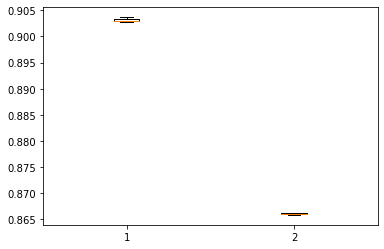

In [6]:
# show boxplot of ten runs

plt.boxplot([mses1, mses2])
#plt.boxplot(mses1)
plt.show()

In [7]:
# drop one column to get rid of colinearity, and train only on genres, userId, year 

X = df.drop(columns = ['rating', '(no genres listed)','title', 'timestamp'])
y = df['rating'].values
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape  
                 
mses3 = []
for i in range(0, 3):
    rfc = RandomForestRegressor()
    rfc.fit(X_train, y_train)
    ypred = rfc.predict(X_test)
    print('Mean Squared Error (MSE): ' + str(mean_squared_error(y_test, ypred)))
    mses3.append(mean_squared_error(y_test, ypred))


        userId  movieId  Action  Adventure  Animation  Children  Comedy  \
0            1        1       0          1          1         1       1   
1            5        1       0          1          1         1       1   
2            7        1       0          1          1         1       1   
3           15        1       0          1          1         1       1   
4           17        1       0          1          1         1       1   
...        ...      ...     ...        ...        ...       ...     ...   
100831     610   160341       1          0          0         0       0   
100832     610   160527       1          0          0         0       0   
100833     610   160836       1          0          0         0       0   
100834     610   163937       0          0          0         0       0   
100835     610   163981       0          0          0         0       0   

        Crime  Documentary  Drama  ...  Horror  IMAX  Musical  Mystery  \
0           0            

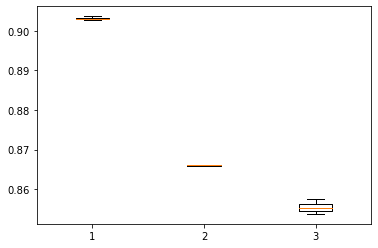

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [8]:
# show boxplot of ten runs

plt.boxplot([mses1, mses2, mses3])
#plt.boxplot(mses1)
plt.show()

import statsmodels.api as sm
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=df.drop(['rating'],axis=1)
calculate_vif(X)


In [ ]:

X = df.drop(['rating', 'Action'], axis=1)
calculate_vif(X)

In [ ]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
ypred = rfc.predict(X_test)
print('Mean Squared Error (MSE): ' + str(mean_squared_error(y_test, ypred)))

In [ ]:
rfc = RandomForestRegressor()
parameters = {'n_estimators':[10, 20], 
              'criterion':["mse", "mae"]
             }
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train, y_train)
print("The best features are: " + str(clf.best_params_))
print("random forest roc_auc_score: " + str(roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test)[:, 1])))
print('Mean Squared Error (MSE): ' + str(mean_squared_error(y_test, clf.best_estimator__.predict_proba(X_test)[:, 1])))


plot_confusion_matrix(clf.best_estimator_, X_test, y_test)  
plt.show()
